### Klasifikasi Ulasan Tokopedia Menggunakan Teknik NLP Untuk Memahami Pola Kepuasan Pelanggan
logo-tokopedia-vector-design-isolated-mascot-tokopedia-logo-icon-vector-template-editorial_771881-288.avif





In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import re
import string

In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/Portofolio_Data/tokopedia-product-reviews-2019.csv')
dataset.head()

,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url
0,1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...
1,2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
2,3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
3,4,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...
4,5,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...


Dataset ini berisikan infomrasi mengenai perilaku pelanggan saat berbelanja menggunakan e-commerce. Dataset ini memiliki beberapa atribut / kolom, namun dalam project ini akan dipilih beberapa fitur seperti "text" dan "rating" supaya selaras dengan tujuan project ini untuk memahami pola kepuasan pelanggan

Terdapat beberapa tahapan pre-processing, seperti:
1. Pemilhan atribut, hal ini dilakukan karena hanya memilih beberapa fitur seperti text dan rating



In [3]:
#pemilihan atribut
df=dataset[['text','rating']]
df.head()

,text,rating
0,Barang sesuai pesanan dan cepat sampai,5
1,Barang bagus harga murah,5
2,Paket rapi...mantap....cepat....sampe ke tujuan,5
3,ya saya puas dgn barangnya,5
4,Responya luar biasa b mantap,5


2. Menghapus data duplikat, ini dilakukan supaya tidak ada data duplikat pada dataset yang dapat menyebabkan double informasi dan akurat.

In [4]:
#Menghapus Data Duplikat
print("jml data duplikat", df.duplicated().sum())
df.drop_duplicates(inplace=True)

jml data duplikat 2938


/tmp/ipython-input-4087493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


3. Pelabelan Data/Label Binary, tahap ini diaplikasikan karena pada kolom rating, terdapat 5 jenis yaitu 1,2,3,4 dan 5. untuk mengurangi adanya bias dan memastikan keseimbangan data, maka dari 5 rating akan di kerucutkan menjadi 2, yaitu 0/negatif untuk rating 1-3 dan rating 4-5 akan digantikan menjadi 1/positif

In [5]:
# Label Binary
df['label'] = df['rating'].apply(lambda x: 1 if x>=4 else 0)

/tmp/ipython-input-1233467903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['rating'].apply(lambda x: 1 if x>=4 else 0)


4. menghapus karakter dan lowercase, proses ini diterapkan untuk menyeragamkan data dan menghindari adanya perbedaan penulisan, maka dari itu menghapus karakter dan lowercase diperlukan.

In [6]:
#Menghapus Karakter dan Lower Case
import regex as re
def clean_data(teks):
    teks = re.sub(r'[^\w\s]', ' ', teks)
    teks = re.sub(r'\d', ' ', teks)
    teks = re.sub(r'\s+', ' ', teks)
    return teks

df['clean'] = df['text'].apply(clean_data).str.lower()
df.head()

/tmp/ipython-input-2033437002.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean'] = df['text'].apply(clean_data).str.lower()


,text,rating,label,clean
0,Barang sesuai pesanan dan cepat sampai,5,1,barang sesuai pesanan dan cepat sampai
1,Barang bagus harga murah,5,1,barang bagus harga murah
2,Paket rapi...mantap....cepat....sampe ke tujuan,5,1,paket rapi mantap cepat sampe ke tujuan
3,ya saya puas dgn barangnya,5,1,ya saya puas dgn barangnya
4,Responya luar biasa b mantap,5,1,responya luar biasa b mantap


5. Vectorizer , setelah data sudah cukup bersih untuk dilakukan pemodelan, maka tahap selajutnya adalah vektorisasi. Ini dilakukan untuk memecah kata menjadi sebuah token dan menghitung bobotnya supaya machine learning dapat dengan mudah mengolah data teks yang telah di konversi menjadi matriks angka.

In [7]:
# Vectorizer / Tokenisasi
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['clean'])
y = df['label']

6. Under Sampling, hal ini diterapkan karena ketidakseimbangan data yang besar antara label 0 dan 1, dilakukan random under sampling supaya data tersebut balance karena akan mempengaruhi hasil machine learning yang baik.

In [11]:
df['label'].value_counts()

,count
label,
1,34955
0,2714


In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy={1:1500}, random_state=42)
x_res, y_res = rus.fit_resample(X, y)

In [20]:
x_res.shape[0], len(y_res)

(4214, 4214)

Wordcloud

Wordcloud digunakan untuk menampilkan frekuensi kemunculan kata baik itu positif atau negatif. wordcloud juga berfungsi untuk mengidentifikasi pola suatu tren dalam bentuk teks.

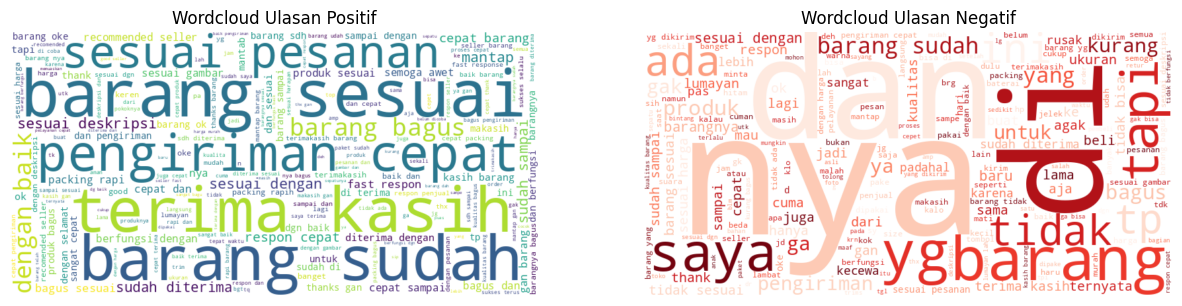

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Pisahkan dataset
positive_text = " ".join(df[df['label']==1]['clean'])
negative_text = " ".join(df[df['label']==0]['clean'])

plt.figure(figsize=(15,6))

# Wordcloud Positive
plt.subplot(1,2,1)
wc_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
plt.imshow(wc_pos, interpolation='bilinear')
plt.title("Wordcloud Ulasan Positif")
plt.axis("off")

# Wordcloud Negative
plt.subplot(1,2,2)
wc_neg = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title("Wordcloud Ulasan Negatif")
plt.axis("off")

plt.show()

Pemodelan

Tahap prepocessing telah selesai dilakukan, maka selanjutnya adalah tahap pemodelan. Kali ini saya menggunakan machine learning Logistic Regression dengan data X berupa text dan y berupa rating yang telah diubah menjadi label.

Menggunakan perbandingan data training dan data testing sebesar 20:80, Logistic Regresion menghasilkan nilai akurasi 76%, precision kelas 0 85%, precision kelas 1 63%, recall kelas 0 76% dan recall kelas 1 76%

In [26]:
#Pemodelan
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

model = LogisticRegression(class_weight='balanced',max_iter=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       543
           1       0.63      0.76      0.69       300

    accuracy                           0.76       843
   macro avg       0.74      0.76      0.74       843
weighted avg       0.77      0.76      0.76       843



Pengujian Model Menggunakan Confusion Matrix

Sebagai indikator kualitas model, confusion matrix membantu analis data untuk memahami sejauh mana model dapat mengenali dan mengklasifikasikan dengan benar setiap kategori dalam data, hasil dari machine learning berikut adalah:
1. Terdapat 410 Data Negatif yang diprediksi sebagai data Negatif = True Negative
2. Terdapat 133 Data Negatif yang diprediksi sebagai data positif = False Positive
3. Terdapat 72 Data Positif yang diprediksi sebagai data Negatif = False Negative
4. Terdapat 228 Data Positif yang diprediksi sebagai data Positif = True Positive

<Figure size 600x500 with 0 Axes>

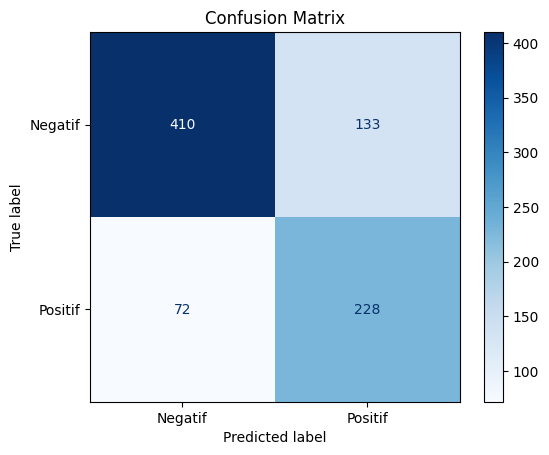

In [31]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negatif", "Positif"])

plt.figure(figsize=(6,5))
disp.plot(values_format='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


Identifikasi Kata - Kata yang penting Untuk Membedakan Kedua Sentimen

Ini bertujuan untuk mengetahui 20 kata kata yangpaling sering muncul dalam ulasan positif dan negatif. ini bisa digunakan untuk dijadikan keyword dalam sebuah toko supaya lebih cepat dalam melakukan analisa, analisa langsung menggunakan komentar lebih powerful dibandingkan dengan rating. hal ini bisa saja terjadi karena pemberian rating terkadang tidak sesuai dengan ulasan yang diberikan, maka dengan adanya analisa ini dapat dijadikan sistem early warning supaya dapat menindaklanjuti jika terdapat ulasan negatif, dan untuk ulasan positif bisa digunakan untuk tindakan apresiasi sebagai bentuk loyalitas kepada pelanggan.

In [30]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
coeffs = model.coef_[0]

# Kata paling positif
top_pos_idx = np.argsort(coeffs)[-20:]
top_pos_words = feature_names[top_pos_idx]

# Kata paling negatif
top_neg_idx = np.argsort(coeffs)[:20]
top_neg_words = feature_names[top_neg_idx]

print("Kata yang paling identik dengan ulasan POSITIF:")
for w in reversed(top_pos_words):
    print("-", w)

print("\nKata yang paling identik dengan ulasan NEGATIF:")
for w in top_neg_words:
    print("-", w)

Kata yang paling identik dengan ulasan POSITIF:
- mantap
- keren
- mantab
- kancing
- pernah
- tulisannya
- best
- kesempitan
- suka
- seller
- murah
- bgs
- luar
- android
- bekerja
- deskripsi
- baguusss
- bagus
- diusahakan
- spesifikasi

Kata yang paling identik dengan ulasan NEGATIF:
- kurang
- rusak
- bermanfaat
- dikirim
- tidak
- tdk
- gak
- tpi
- habis
- blm
- dibungkus
- patah
- jelek
- lumayanlah
- harga
- lebih
- mati
- berbeda
- harganya
- namun
